In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, 
    accuracy_score, f1_score, roc_curve, auc, precision_score, recall_score,
    ConfusionMatrixDisplay, balanced_accuracy_score
)
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from catboost import CatBoostClassifier
import lightgbm as lgb
plt.style.use('ggplot')
%matplotlib inline
sns.set_palette("pastel")


In [29]:
df = pd.read_csv('datas.csv') 
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [31]:
def convert_numeric_columns(df):
    print("Tipos de datos originales:")
    print(df.dtypes)
    print("\n" + "="*50)
    
    # Identificar columnas que deberían ser numéricas pero son object
    numeric_as_object = []
    for col in df.columns:
        if df[col].dtype == 'object':
            # Intentar convertir a numérico
            converted = pd.to_numeric(df[col], errors='coerce')
            # Si más del 80% de los valores se pueden convertir, es probable que sea numérica
            if converted.notna().sum() / len(df) > 0.8:
                numeric_as_object.append(col)
    
    print(f"Variables identificadas como numéricas pero en object: {numeric_as_object}")
    
    # Convertir las variables identificadas
    for col in numeric_as_object:
        df[col] = pd.to_numeric(df[col], errors='coerce')
        print(f"Convertida {col} a numérica. Valores nulos creados: {df[col].isna().sum()}")
    
    # Conversiones específicas para las variables comunes
    if 'TotalCharges' in df.columns and df['TotalCharges'].dtype == 'object':
        df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
        print("TotalCharges convertida a numérica")
    
    if 'MonthlyCharges' in df.columns and df['MonthlyCharges'].dtype == 'object':
        df['MonthlyCharges'] = pd.to_numeric(df['MonthlyCharges'], errors='coerce')
        print("MonthlyCharges convertida a numérica")
    
    if 'tenure' in df.columns and df['tenure'].dtype == 'object':
        df['tenure'] = pd.to_numeric(df['tenure'], errors='coerce')
        print("tenure convertida a numérica")
    
    print("\nTipos de datos después de la conversión:")
    print(df.dtypes)
    print("\n" + "="*50)
    
    return df

convert_numeric_columns(df)

Tipos de datos originales:
customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

Variables identificadas como numéricas pero en object: ['TotalCharges']
Convertida TotalCharges a numérica. Valores nulos creados: 11

Tipos de datos después de la conversión:
customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         objec

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.50,No
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.90,No
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.60,Yes


In [32]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000,7032.000000
mean,0.162147,32.371149,64.761692,2283.300441
std,0.368612,24.559481,30.090047,2266.771362
min,0.000000,0.000000,18.250000,18.800000
25%,0.000000,9.000000,35.500000,401.450000
50%,0.000000,29.000000,70.350000,1397.475000
75%,0.000000,55.000000,89.850000,3794.737500
max,1.000000,72.000000,118.750000,8684.800000


In [33]:
print("\nValores nulos por columna:")
print(df.isnull().sum())

# Eliminamos columna innecesaria si existe
if 'Unnamed: 0' in df.columns:
    df.drop('Unnamed: 0', axis=1, inplace=True)

# Verificamos duplicados
print("\nNúmero de duplicados:", df.duplicated().sum())

# Eliminar duplicados si los hay
df = df.drop_duplicates()




Valores nulos por columna:
customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

Número de duplicados: 0


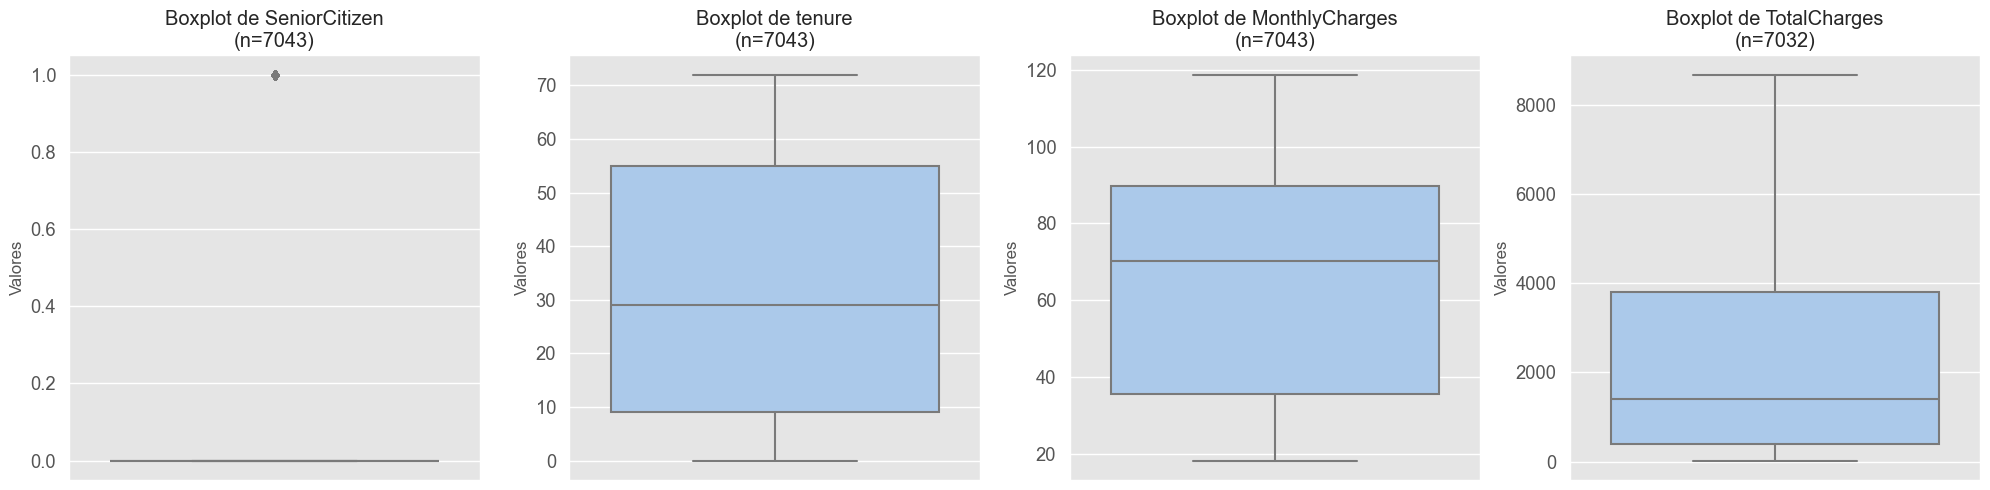

In [34]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

def plot_outliers_comprehensive(df):
    # Obtener todas las columnas numéricas
    numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
    
    # Calcular cuántos subplots necesitamos
    n_cols = len(numeric_cols)
    n_rows = (n_cols + 3) // 4  # 4 columnas por fila
    
    # Crear la figura
    plt.figure(figsize=(20, 5 * n_rows))
    
    # Crear boxplots para cada variable numérica
    for i, col in enumerate(numeric_cols):
        plt.subplot(n_rows, 4, i+1)
        sns.boxplot(y=df[col])
        plt.title(f'Boxplot de {col}\n(n={len(df[col].dropna())})')
        plt.ylabel('Valores')
    
    plt.tight_layout()
    plt.show()
    
    return numeric_cols

# Usar la función
numeric_columns = plot_outliers_comprehensive(df)

In [35]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
import warnings
warnings.filterwarnings("ignore")

# Verificar la variable objetivo
print("Valores únicos en la variable objetivo:")
print(df['Churn'].value_counts())
print(f"\nTipo de dato: {df['Churn'].dtype}")

# Opción 1A: Label Encoding (0 y 1)
df['Churn_encoded'] = LabelEncoder().fit_transform(df['Churn'])
print("\nDespués de Label Encoding:")
print(df['Churn_encoded'].value_counts())

# Opción 1B: Mapeo manual (más control)
df['Churn_encoded'] = df['Churn'].map({'No': 0, 'Yes': 1})
# O si tienes otros valores:
# df['Churn_encoded'] = df['Churn'].map({'No': 0, 'Yes': 1, 'Other': 2})

print("\nVerificación del mapeo:")
print(pd.crosstab(df['Churn'], df['Churn_encoded']))

def proporcion_columna(df, column):
    counts = df[column].value_counts()
    proportions = counts / len(df) * 100
    result = pd.DataFrame({'Count': counts, 'Proportion (%)': proportions})
    return result
proporcion_columna(df, 'Churn_encoded')

Valores únicos en la variable objetivo:
Churn
No     5174
Yes    1869
Name: count, dtype: int64

Tipo de dato: object

Después de Label Encoding:
Churn_encoded
0    5174
1    1869
Name: count, dtype: int64

Verificación del mapeo:
Churn_encoded     0     1
Churn                    
No             5174     0
Yes               0  1869


,Count,Proportion (%)
Churn_encoded,,
0,5174,73.463013
1,1869,26.536987


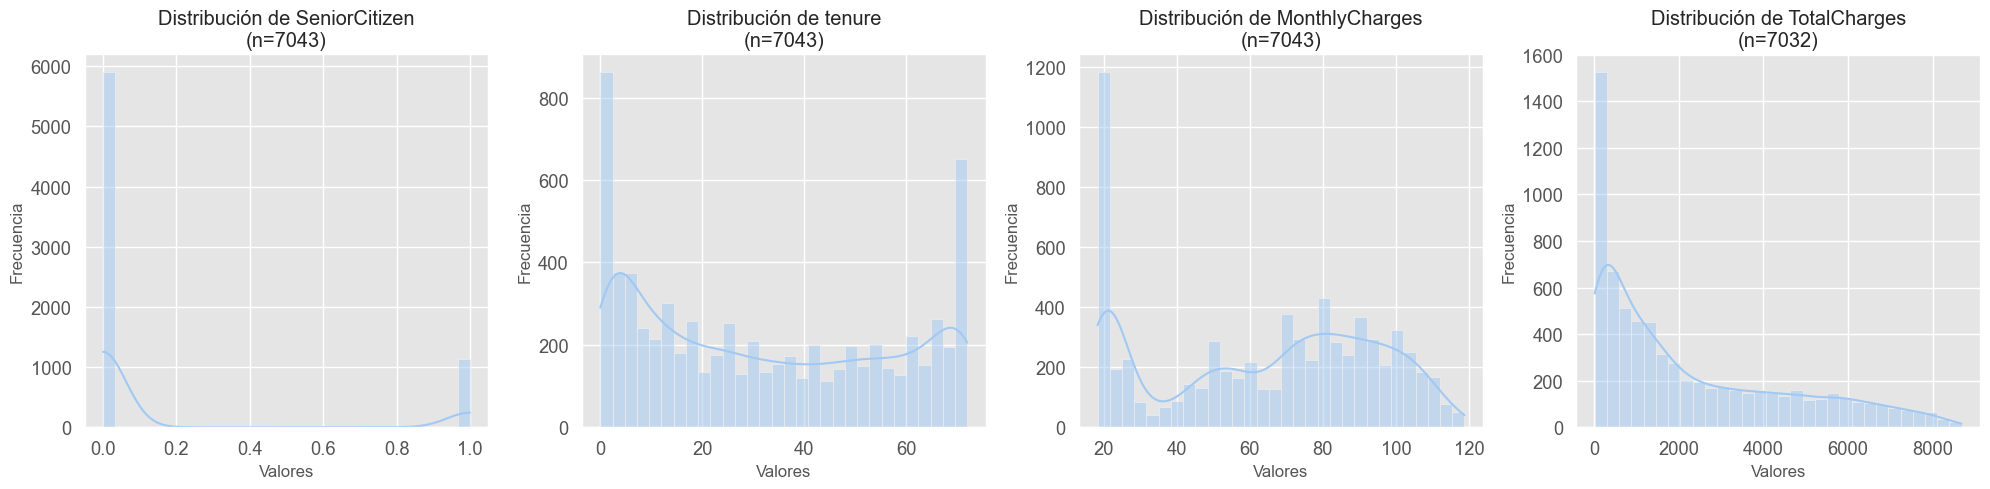

In [36]:
def distribucion_datos(df, numeric_columns):
    # Calcular cuántos subplots necesitamos
    n_cols = len(numeric_columns)
    n_rows = (n_cols + 3) // 4  # 4 columnas por fila
    
    # Crear la figura
    plt.figure(figsize=(20, 5 * n_rows))
    
    # Crear histogramas para cada variable numérica
    for i, col in enumerate(numeric_columns):
        plt.subplot(n_rows, 4, i+1)
        sns.histplot(df[col].dropna(), kde=True, bins=30)
        plt.title(f'Distribución de {col}\n(n={len(df[col].dropna())})')
        plt.xlabel('Valores')
        plt.ylabel('Frecuencia')
    
    plt.tight_layout()
    plt.show()
# Usar la función
distribucion_datos(df, numeric_columns)

Matriz de correlación: (5, 5)


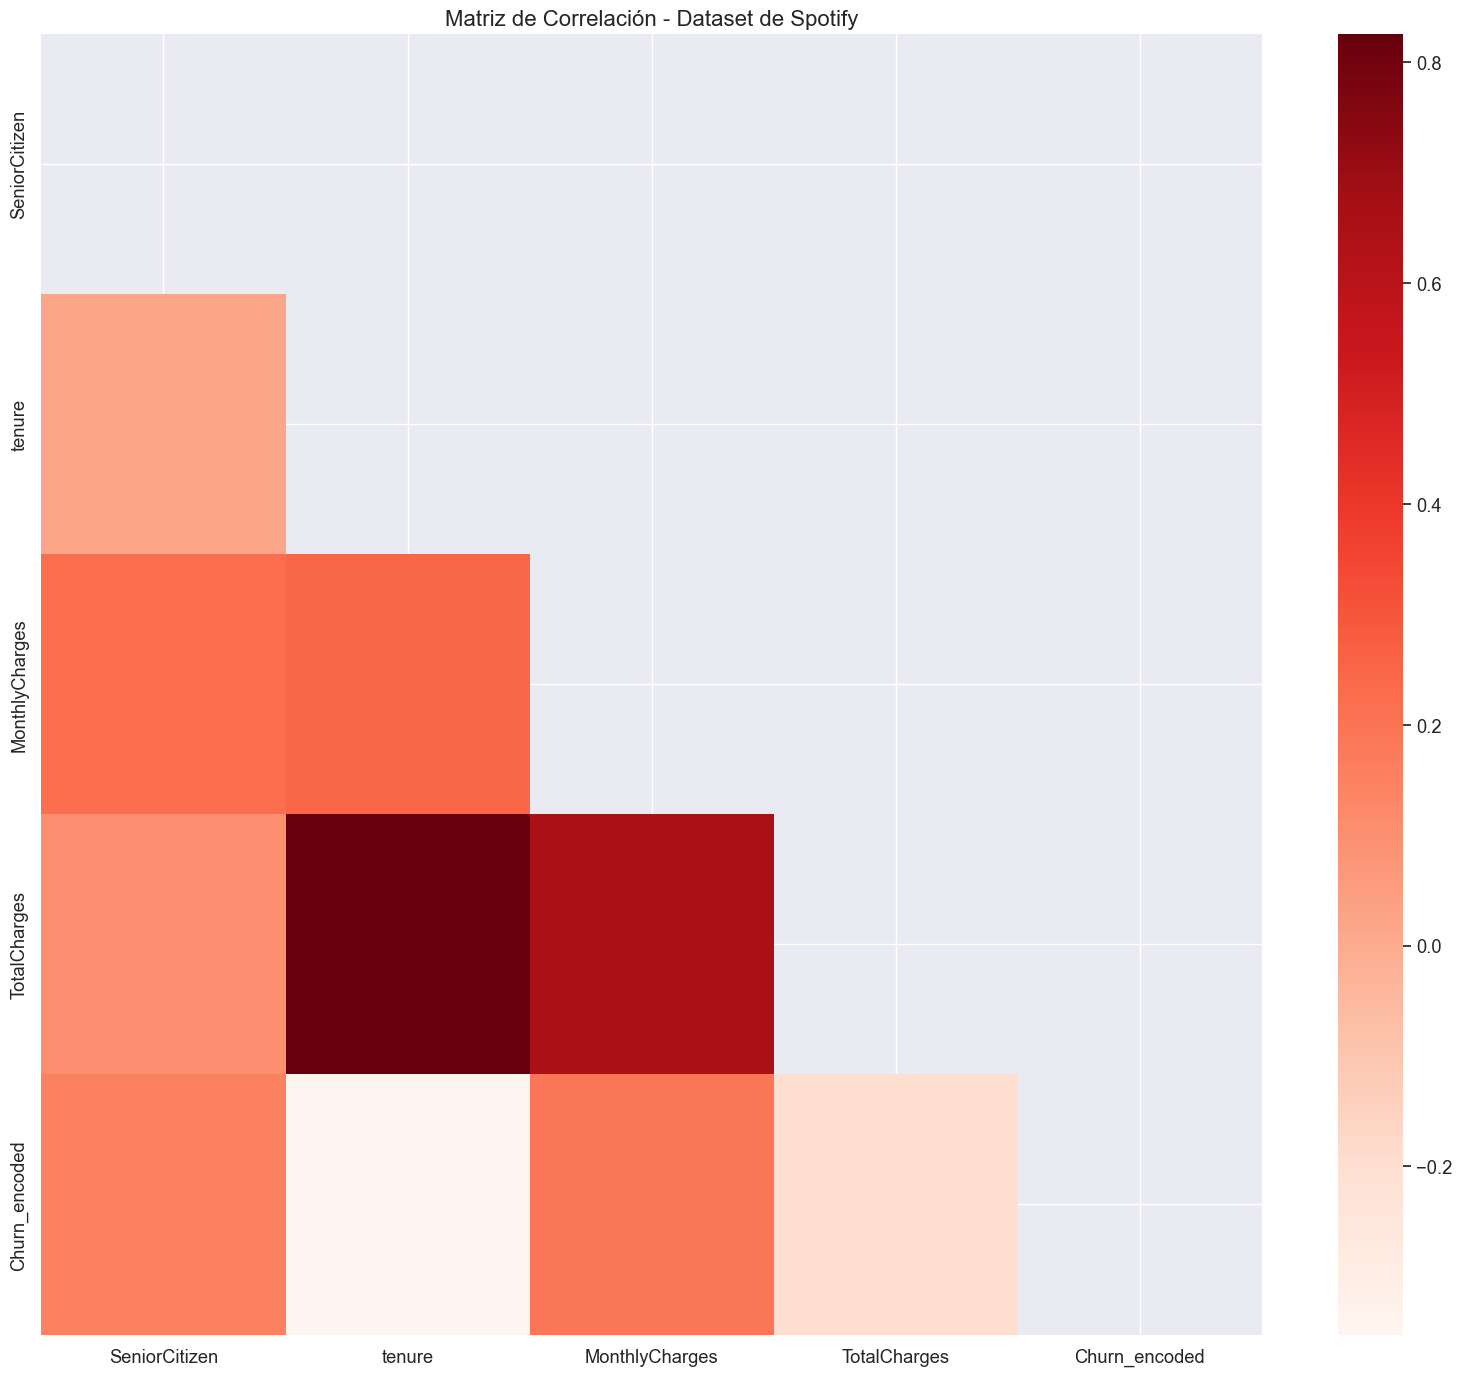

In [37]:
# Calcular la matriz de correlación
spotify_num = df.select_dtypes(include=np.number)

corr = spotify_num.corr()
print("Matriz de correlación:", corr.shape)

# Crear la máscara para ocultar la mitad superior
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

# Configurar el estilo y mostrar el mapa de calor
sns.set(font_scale=1.2)
plt.figure(figsize=(16, 14))
sns.heatmap(corr, mask=mask, cmap='Reds', annot=True, fmt='.2f', annot_kws={"size": 12}, cbar=True)
plt.title("Matriz de Correlación - Dataset de Spotify", fontsize=16)
plt.tight_layout()
plt.show()

In [38]:
def clone_pipeline(pipeline):
    """
    Clona un pipeline de sklearn correctamente
    """
    from sklearn.pipeline import Pipeline
    from sklearn.base import clone
    
    if isinstance(pipeline, Pipeline):
        # Clonar cada paso del pipeline
        steps = []
        for name, step in pipeline.steps:
            steps.append((name, clone(step)))
        return Pipeline(steps)
    else:
        return clone(pipeline)

def evaluate_model(model, X_train, X_test, y_train, y_test, model_name, cv_folds=5):
    """
    Evalúa un modelo y retorna métricas completas - VERSIÓN CORREGIDA
    """
    import time
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
    from sklearn.model_selection import StratifiedKFold
    import numpy as np
    
    start_time = time.time()
    
    # Entrenar el modelo
    model.fit(X_train, y_train)
    train_time = time.time() - start_time
    
    # Predecir
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None
    
    # Métricas
    accuracy = accuracy_score(y_test, y_pred)
    precision_macro = precision_score(y_test, y_pred, average='macro', zero_division=0)
    recall_macro = recall_score(y_test, y_pred, average='macro', zero_division=0)
    f1_macro = f1_score(y_test, y_pred, average='macro', zero_division=0)
    
    # AUC (solo si hay probabilidades)
    auc_score = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else None
    
    # Cross-validation score - VERSIÓN SIMPLIFICADA Y SEGURA
    cv_scores = []
    try:
        cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)
        
        for train_idx, val_idx in cv.split(X_train, y_train):
            X_train_cv, X_val_cv = X_train.iloc[train_idx], X_train.iloc[val_idx]
            y_train_cv, y_val_cv = y_train.iloc[train_idx], y_train.iloc[val_idx]
            
            # Clonar el pipeline completo
            model_clone = clone_pipeline(model)
            model_clone.fit(X_train_cv, y_train_cv)
            y_pred_cv = model_clone.predict(X_val_cv)
            cv_scores.append(f1_score(y_val_cv, y_pred_cv, average='macro', zero_division=0))
        
        cv_mean = np.mean(cv_scores)
    except Exception as e:
        print(f"⚠️  Error en CV para {model_name}: {e}")
        cv_mean = None
    
    return {
        'model': model_name,
        'accuracy': accuracy,
        'precision_macro': precision_macro,
        'recall_macro': recall_macro,
        'f1_macro': f1_macro,
        'auc': auc_score,
        'cv_score': cv_mean,
        'train_time': train_time,
        'model_object': model
    }

In [39]:
# Verificar la variable objetivo
print(f"\nDistribución de Churn (variable objetivo):")
print(df['Churn'].value_counts())
print(df['Churn'].value_counts(normalize=True))

# Convertir variable objetivo a numérica
df['Churn_encoded'] = df['Churn'].map({'Yes': 1, 'No': 0})


Distribución de Churn (variable objetivo):
Churn
No     5174
Yes    1869
Name: count, dtype: int64
Churn
No     0.73463
Yes    0.26537
Name: proportion, dtype: float64


In [40]:
# Identificar tipos de variables
numeric_features = []
categorical_features = []

for col in df.columns:
    if col not in ['customerID', 'Churn', 'Churn_encoded']:
        if df[col].dtype in ['int64', 'float64']:
            numeric_features.append(col)
        else:
            categorical_features.append(col)

print(f"\nCaracterísticas numéricas ({len(numeric_features)}): {numeric_features}")
print(f"Características categóricas ({len(categorical_features)}): {categorical_features}")

# Variable objetivo
X = df[numeric_features + categorical_features]
y = df['Churn_encoded']

print(f"\nDistribución de clases:")
print(f"   Clase 0 (No Churn): {sum(y == 0)} muestras ({sum(y == 0)/len(y)*100:.1f}%)")
print(f"   Clase 1 (Churn):    {sum(y == 1)} muestras ({sum(y == 1)/len(y)*100:.1f}%)")


Características numéricas (4): ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']
Características categóricas (15): ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']

Distribución de clases:
   Clase 0 (No Churn): 5174 muestras (73.5%)
   Clase 1 (Churn):    1869 muestras (26.5%)


In [41]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nParticiones:")
print(f"   Training: {X_train.shape[0]} muestras")
print(f"   Test:     {X_test.shape[0]} muestras")

print(f"\nDistribución de clases en entrenamiento:")
print(f"   Clase 0 (No Churn): {sum(y_train == 0)} muestras ({sum(y_train == 0)/len(y_train)*100:.1f}%)")
print(f"   Clase 1 (Churn):    {sum(y_train == 1)} muestras ({sum(y_train == 1)/len(y_train)*100:.1f}%)")

# =============================================================================
# PREPROCESADOR
# =============================================================================

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

# =============================================================================
# LISTA PARA ALMACENAR RESULTADOS
# =============================================================================
results = []


Particiones:
   Training: 5634 muestras
   Test:     1409 muestras

Distribución de clases en entrenamiento:
   Clase 0 (No Churn): 4139 muestras (73.5%)
   Clase 1 (Churn):    1495 muestras (26.5%)


In [42]:
# =============================================================================
# GUARDAR DATOS PROCESADOS PARA USO EN ENTRENAMIENTO (Versión con diccionario)
# =============================================================================
import joblib
import os

os.makedirs("app", exist_ok=True)

# Crear un diccionario con nombres de clave
data_dict = {
    "X_train": X_train,
    "X_test": X_test,
    "y_train": y_train,
    "y_test": y_test
}

# Guardar el diccionario completo
joblib.dump(data_dict, "app/data_splits.joblib")

print("✅ Datos guardados correctamente en formato diccionario en: app/data_splits.joblib")


✅ Datos guardados correctamente en formato diccionario en: app/data_splits.joblib
